<a href="https://colab.research.google.com/github/nicoelbert/vehicleroutingproblem/blob/main/vehicle_routing_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Vehicle Routing Problem
vehicle routing problem on complete information using simmulated annealing

#Preparation

In [1]:
#inital run
if True:
  !pip install pulp
  #!git clone 'https://github.com/nicoelbert/vehicleroutingproblem'
  %cd vehicleroutingproblem

[WinError 2] Das System kann die angegebene Datei nicht finden: 'vehicleroutingproblem'
C:\Users\Nutzer\Documents\GitHub\vehicleroutingproblem


In [2]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import logging

#custom calsses
#!git pull
from classes import classes as cl
from functions import functions as fc
from functions import routing as rt

#connect drive for exports
#!pip install google
#from google.colab import drive
#drive.mount('/content/drive')
string_exp_path = 'output'


In [3]:
logging.basicConfig(filename="inital_routing.log", level=logging.INFO)


In [4]:
#!git pull
#ls()

##Data Import

In [5]:
def get_proxdepot(site,plant):
  
  distance_min = 10000000000000
  depot_min = ''
  for d in list_depots:
    distance_ges = rt.get_distance(d,site) + rt.get_distance(d,plant)
    if distance_ges < distance_min:
      distance_min = distance_ges
      depot_min = d
  return depot_min


In [6]:
#depot masterdata
fc.print_log("Starting with Data Import at {}".format(fc.get_time()))



#load Masterdata from csv
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/Depots.csv'
df_depots = pd.read_csv(url)


#load basetable
url = 'https://raw.githubusercontent.com/nicoelbert/vehicleroutingproblem/main/original_data/preparedJobs.csv'
df_jobs_org = pd.read_csv(url)

#create and fill dict_depots

dict_depots = {}
list_depots = []

for index, row in df_depots.iterrows():
  depot = cl.Depot(row['Werk'],row['Werk_lon'],row['Werk_lat'])
  dict_depots[row['Werk']] = depot
  list_depots.append(depot)


fc.print_log("{} depots created".format(len(dict_depots)))

#create and fill plants from df_jobs_org
dict_plants = {}
list_plants = []

list_plant_names = df_jobs_org['Werk'].unique() 

for pn in list_plant_names:
  row = df_jobs_org[df_jobs_org['Werk'] == pn].iloc[0]
  plant = cl.Plant(row.Werk,row.Werk_lon,row.Werk_lat)
  dict_plants[plant.name] = plant
  list_plants.append(plant)

fc.print_log("{} plants created".format(len(dict_plants)))

#create and fill sites from df_jobs_org

dict_sites = {}
list_sites = []

df_sites = df_jobs_org[['plz','lon','lat']].copy()
df_sites.drop_duplicates(inplace=True)


for index, row in df_sites.iterrows():
  site = cl.Site(row.plz,row.lon,row.lat)
  dict_sites[site.name] = site
  list_sites.append(site)


fc.print_log("{} sites created".format(len(dict_sites)))

#create and fill jobs from df_jobs_org
dict_jobs = {}
list_jobs = []
list_emsen_jobs = []

for index, row in df_jobs_org.iterrows():
  plant = dict_plants[row.Werk]
  site_name = str(row.plz) + '/' +str(row.lon) + '/' + str(row.lat)
  site = dict_sites[site_name]
  prox_depot = get_proxdepot(site,plant)
  job = cl.Job(row.id, row.key, plant,row.Maschinentechnik,row.Material,row.Start_clean,(row.Start_clean + row.Werktage), row.Werktage, site, prox_depot )
  dict_jobs[job.name] = job
  list_jobs.append(job)


fc.print_log("{} jobs created".format(len(dict_jobs)))

#create list of days
# since the timespan is 1208 days and there are only 895 relevant days lets work with these first

list_days = []


for j in list_jobs: 
  if j.start not in list_days:
    list_days.append(j.start)
  if j.end not in list_days:
    list_days.append(j.end)

list_days.sort()
fc.print_log("Working with {} relevant days".format(len(list_days)))

#create one tour for each day and depot

dict_tours = {}
total_tours_created = 0

for depot in dict_depots:
  dict_tours[depot] = {}

for depot in list_depots:
  for day in list_days:
    dict_tours[depot.name][day] = cl.Tour(depot,day)
  total_tours_created += len(dict_tours[depot.name])

fc.print_log("{} tours created".format(total_tours_created))
    
fc.print_log("Done with Data Import at {}".format(fc.get_time()))

Starting with Data Import at 11:46:23
15 depots created
8 plants created
6166 sites created
53178 jobs created
Working with 895 relevant days
13425 tours created
Done with Data Import at 11:46:36


Visualize Data


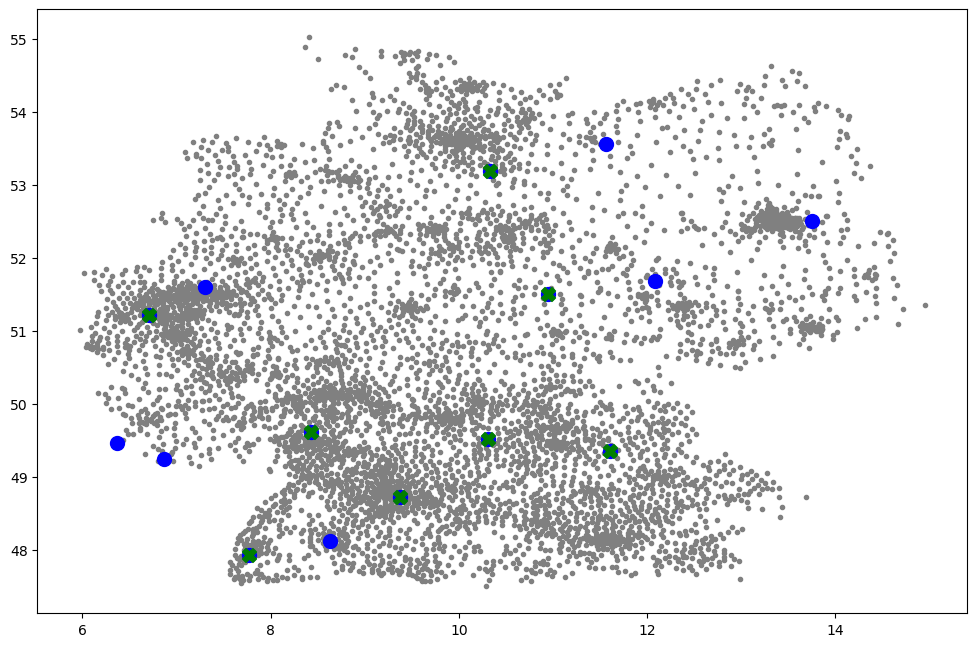

In [7]:
fc.get_map(list_depots,list_plants,list_sites)

Inital Solution

In [8]:
#create inital solution
""" every silo is delivered on the day it is needed and picked up the day it is not needed anymore, the tour swichtes between plant and sites - starting and ending at the depot"""

fc.print_log("Starting with inital solution at {}".format(fc.get_time()))

for j in list_jobs: 
  j.dropoff_day = j.start
  j.pickup_day = j.end
  j.dropoff_depot = j.prox_depot
  j.pickup_depot = j.prox_depot

  #assign inital tours
  j.dropoff_tour = dict_tours[j.dropoff_depot.name][j.dropoff_day]
  j.pickup_tour = dict_tours[j.pickup_depot.name][j.pickup_day]

  #insert jobs and plants into tours for dropoff and pickup
  if j not in j.dropoff_tour.list_dropoffs:
    j.dropoff_tour.list_dropoffs.append(j)
  if j.plant not in j.dropoff_tour.list_plants:
    j.dropoff_tour.list_plants.append(j.plant)
  
  if j not in j.pickup_tour.list_pickups:
    j.pickup_tour.list_pickups.append(j)
  if j.plant not in j.pickup_tour.list_plants:
    j.pickup_tour.list_plants.append(j.plant)
  

i_pickups = 0
i_dropoffs = 0
i_multiple_plants = 0

for depot in dict_depots:
  for day in list_days:
   i_pickups = i_pickups + len(dict_tours[depot][day].list_pickups)
   i_dropoffs = i_dropoffs + len(dict_tours[depot][day].list_dropoffs)
   if len(dict_tours[depot][day].list_plants) > 1:
     i_multiple_plants = i_multiple_plants + 1
     fc.print_log("Warning at Tour from {} and day {} - {} plants listed".format(depot,day,len(dict_tours[depot][day].list_plants)))
     p_names = []
     for p in dict_tours[depot][day].list_plants:
       p_names.append(p.name)
     print(p_names)


total_tours = 0
used_tours = 0
total_distance = 0
sys.setrecursionlimit(100000) # for export

for depot in dict_depots:
  for day in list_days:
    if len(dict_tours[depot][day].list_plants)>0:
      #rt.routing(dict_tours[depot][day])
      print("Distance for depot {} on day {} is {} - {}/{}  done - {} filled - {} plant(s) detected - t: {}".format(depot,day,dict_tours[depot][day].total_distance,total_tours,total_tours_created,used_tours,len(dict_tours[depot][day].list_plants),fc.get_time()),end='\x1b[1K\r')
      logging.info("Distance for depot {} on day {} is {} - {}/{} done - {} filled - {} plant(s) detected - t: {}".format(depot,day,dict_tours[depot][day].total_distance,total_tours,total_tours_created,used_tours,len(dict_tours[depot][day].list_plants),fc.get_time()))
      total_distance += dict_tours[depot][day].total_distance
      used_tours += 1  
    for i in range(30):
        if total_tours == i*500:
            #export all data objects
            fc.save_object(dict_depots, string_exp_path +'/quicksave/{}_dict_depots.pkl'.format(total_tours))
            fc.save_object(dict_sites,  string_exp_path +'/quicksave/{}_dict_sites.pkl'.format(total_tours))
            fc.save_object(dict_plants, string_exp_path +'/quicksave/{}_dict_plants.pkl'.format(total_tours))
            fc.save_object(dict_jobs,  string_exp_path +'/quicksave/{}_dict_jobs.pkl'.format(total_tours))
            fc.save_object(dict_tours,  string_exp_path +'/quicksave/{}_dict_tours.pkl'.format(total_tours))
    total_tours += 1
  

fc.print_log("There are {} dropoffs and {} pickups listet which creates a difference of {}".format(i_dropoffs,i_pickups,i_dropoffs-i_pickups))
fc.print_log("Done with inital solution at {} - total distance: {} - for {} total tours and {} filled".format(fc.get_time(),total_distance, total_tours, used_tours)) 

Starting with inital solution at 11:46:36
Warning at Tour from Neuherberg and day 16882 - 2 plants listed
['Lauterhofen', 'Neuherberg']
Warning at Tour from Neuherberg and day 16900 - 2 plants listed
['Lauterhofen', 'Neuherberg']
Warning at Tour from Embsen and day 17031 - 2 plants listed
['Embsen', 'Rottleberode']
Warning at Tour from Embsen and day 17042 - 2 plants listed
['Embsen', 'Rottleberode']
There are 53178 dropoffs and 53178 pickups listet which creates a difference of 0d - 1 plant(s) detected - t: 11:46:44
Done with inital solution at 11:46:48 - total distance: 0 - for 13425 total tours and 6201 filled


Persitate Inital Solution

In [9]:
fc.print_log("Starting persitation at {}".format(fc.get_time()))

tour_cols = dict_tours['Embsen'][17042].get_colums()

#create df with objects and readable df for solution
i=0
tour_df = pd.DataFrame([tour_cols])
tour_df.columns = tour_cols
tour_df_readable = pd.DataFrame([tour_cols])
tour_df_readable.columns = tour_cols

for depot in dict_depots:
  for day in list_days:
    t = dict_tours[depot][day]
    tour_df.loc[i] = t.get_all_values()
    tour_df_readable.loc[i] = t.get_all_value_readable()
    i += 1



sys.setrecursionlimit(100000)

#export tabular tour data
tour_df.to_csv(string_exp_path + '/tour_df.csv')
tour_df_readable.to_csv(string_exp_path + '/tour_df_readable.csv')


#export all data objects
fc.save_object(dict_depots, string_exp_path +'/dict_depots.pkl')
fc.save_object(dict_sites,  string_exp_path +'/dict_sites.pkl')
fc.save_object(dict_plants, string_exp_path +'/dict_plants.pkl')
fc.save_object(dict_jobs,  string_exp_path +'/dict_jobs.pkl')
fc.save_object(dict_tours,  string_exp_path +'/dict_tours.pkl')
logging.info("objects saved")


fc.print_log("Done with persitation at {}".format(fc.get_time()))

Starting persitation at 11:46:48


C:\Users\Nutzer\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:849: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  arr_value = np.array(value)


Done with persitation at 11:48:49


In [10]:
tour_df

,day,depot,list_plants,list_pickups,list_dropoffs,total_jobs,total_distance,routing_sequence,worst_edge_pickup,worst_edge_distance,worst_edge_dropoff,edges,distance_uptodate
0,16485,<classes.classes.Depot object at 0x000002D1392...,[<classes.classes.Plant object at 0x000002D13A...,[],[<classes.classes.Job object at 0x000002D13DB8...,0,0,[],,,0,0,True
1,16527,<classes.classes.Depot object at 0x000002D1392...,[],[],[],0,0,[],,,0,0,True
2,16528,<classes.classes.Depot object at 0x000002D1392...,[],[],[],0,0,[],,,0,0,True
3,16535,<classes.classes.Depot object at 0x000002D1392...,[<classes.classes.Plant object at 0x000002D13A...,[],[<classes.classes.Job object at 0x000002D13DB8...,0,0,[],,,0,0,True
4,16544,<classes.classes.Depot object at 0x000002D1392...,[<classes.classes.Plant object at 0x000002D13A...,[],[<classes.classes.Job object at 0x000002D13DB8...,0,0,[],,,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13420,17545,<classes.classes.Depot object at 0x000002D13A6...,[],[],[],0,0,[],,,0,0,True
13421,17546,<classes.classes.Depot object at 0x000002D13A6...,[],[],[],0,0,[],,,0,0,True
13422,17547,<classes.classes.Depot object at 0x000002D13A6...,[],[],[],0,0,[],,,0,0,True
13423,17548,<classes.classes.Depot object at 0x000002D13A6...,[],[],[],0,0,[],,,0,0,True


In [ ]:
tour_df_readable

##Backup

In [ ]:
#notes
"""tour contains list of pickup and dropoff node,

"inital solution transport every silo back and forth on a tour prior to the"
"create a tour with list of pickups and list of deliveries - also need to include silo types?"""

In [ ]:
#question
""""really repos or whole problem?"



"how many silos"
"max_km"
"how early"""

In [ ]:
#assumption
"""
max_km? 
max_tour/depot = 1

In [ ]:
#backup

#distance depot,plants
"""
for d in list_depots:
  for p in list_plants:
    print('{} nach {} sind {}'.format(d.name,p.name,fc.get_distance(d,p)))
"""

"""
"eval of sites"
print(len(df_jobs['plz'].unique()))
print(len(df_jobs['lon'].unique()))
print(len(df_jobs['lat'].unique()))
#print(len(df_jobs[['lon','lat']]()))

df_sites = df_jobs[['lon','lat']].copy()

print(df_sites.shape)

df_sites.drop_duplicates(inplace=True)


print(df_sites.shape)
k.key
"""
